### LSST AGN SC Classification Example; Adding Variability

Gordon Richards and Weixiang Yu, Drexel University, May 2020

This notebook contains example code for learning how to use the AGN training set in the SciServer environment.  See https://github.com/RichardsGroup/LSST_training.
This example was developed specifically to support Gordon Richards' talk at the AGN SC's meeting-in-a-meeting at the virtual AAS in June 2020.

In [1]:
#Load the various packages that we'll need
import numpy as np 
import pandas as pd #to enable the use of fancy data tables
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn #SciKit-Learn machine learning package for python
import zarr #See Setup.ipynb
pd.set_option('display.max_columns', 999)
from utils import * #See Setup.ipynb
import seaborn as sea
from scipy import stats

#So that plots will be displayed inline
%matplotlib inline 

In [2]:
import palettable

#See colorbrewer2.org
#4-class PuOr
#$cmap="PuOr"
cspuor = palettable.colorbrewer.diverging.PuOr_4.mpl_colors

#4-class Dark
csdark = palettable.colorbrewer.qualitative.Dark2_4.mpl_colors

#4-class Paired
cspaired = palettable.colorbrewer.qualitative.Paired_4.mpl_colors

#6-class sequential
cspurples = palettable.colorbrewer.sequential.Purples_6.mpl_colors
csoranges = palettable.colorbrewer.sequential.Oranges_6.mpl_colors
csblues = palettable.colorbrewer.sequential.Blues_6.mpl_colors
csgreens = palettable.colorbrewer.sequential.Greens_6.mpl_colors
csreds = palettable.colorbrewer.sequential.Reds_6.mpl_colors
csgreys = palettable.colorbrewer.sequential.Greys_6.mpl_colors

In [3]:
## If using SciServer
# See Get_started.ipynb

# assign the data directory to data_dir
data_dir = '/home/idies/workspace/Storage/ywx649999311/AGN_training/AAS_Data'

# Initiate connection with data directory
init(data_dir)

In [4]:
#Setup defaults for plotting

def figsze(hscale, vscale=(np.sqrt(5.0)-1.0)/2.0, fig_width_pt = 800.0):
    """
    Get the fig_width_pt by inserting \the\textwidth into LaTeX document.

    hscale is fraction of text width you want.

    vscale is fraction of hscale (defaults to golden ratio)  
    """
   
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt*hscale   # width in inches
    fig_height = fig_width#*vscale                   # height in inches
    fig_size = [fig_width/2+2,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "axes.linewidth":1.2,               # width of box, 2 is too wide, 1 is too narrow
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 24,               # LaTeX default is 10pt font, font size of axis text label
    "axes.labelpad" : 6,                # Distance between label and axis    
    "axes.formatter.limits":[-99,99],   # use sci notation if log10 of axis range is smaller than first or larger than second.
                                        # GTR: Actually *don't* -- should change the axis label instead.  E.g., "Flux Density (10^-17 ergs/s/cm^2)" 
                                        # This is a hack b/c there doesn't seem to be an rcParams version of
                                        # axes.ticklabel_format(style='plain')
    #"axes.formatter.style":"plain",    # Turn off multiplicative offsets (sci notation) to the axes [GTR: Doesn't work]
    "axes.formatter.useoffset":False,   # Turn off additive offsets to the axes
    "font.size": 24,
    "legend.fontsize": 24,              # Make the legend/label fonts a little smaller
    "xtick.labelsize": 24,              # Font size of numbers 
    "ytick.labelsize": 24,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.top":True,
    "xtick.minor.top":True,
    "ytick.major.right":True,
    "ytick.minor.right":True,
    'xtick.major.width':1.0, 
    'xtick.minor.width':1.0, 
    'ytick.major.width':1.0, 
    'ytick.minor.width':1.0, 
    'xtick.major.size':8,             # size of tickmarks in points
    'xtick.minor.size':4, 
    'ytick.major.size':8, 
    'ytick.minor.size':4,
    'xtick.major.pad':8,               # distance between box and numbers
    'ytick.major.pad':8,
    "figure.figsize": figsze(1,1),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts because your computer can handle it
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

mpl.rcParams.update(pgf_with_latex)

In [5]:
#Define function that will be used to make plot similar to scatter_dot in SM

def contour_scatter(x, y, exkernel=None, ax=None, color='C0', cmap='Blues_r',
                    lims=None, levels=None, scatter=True, nlevel=1,
                    kwargs_contour={},
                    kwargs_plot={}):
    """ Contour and scatter plot with no points inside contours """


    if ax is None:
        ax = plt.gca()
    # fig, ax = plt.subplots(1)
    if lims is None:
        xmin = x.min()
        xmax = x.max()
        ymin = y.min()
        ymax = y.max()
    else:
        xmin, xmax, ymin, ymax = lims

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

    CS = ax.contour(X,
                    Y,
                    Z,
                    cmap=cmap,
                    levels=levels,
                    **kwargs_contour)

    if scatter is True:
        print(CS.levels)
        threshold = CS.levels[nlevel] # nlevel=1 or 0 depending on Python version?
        z = kernel(values)

        # mask points above density threshold
        x = np.ma.array(x)
        y = np.ma.array(y)
        if exkernel:
            exz = exkernel(values)
            x[exz > threshold] = np.ma.masked
            y[exz > threshold] = np.ma.masked

        x[z > threshold] = np.ma.masked
        y[z > threshold] = np.ma.masked

        ax.scatter(x, y, color=color, **kwargs_plot)

    if exkernel is False:
        return kernel

    return ax  # x[~x.mask], y[~y.mask]


In [6]:
#Define function that will be used to make plot similar to scatter_dot in SM
#This version plots contours in just one color

def contour_scatter2(x, y, exkernel=None, ax=None, color='C0',
                    lims=None, levels=None, scatter=True, nlevel=1,
                    kwargs_contour={},
                    kwargs_plot={}):
    """ Contour and scatter plot with no points inside contours """


    if ax is None:
        ax = plt.gca()
    # fig, ax = plt.subplots(1)
    if lims is None:
        xmin = x.min()
        xmax = x.max()
        ymin = y.min()
        ymax = y.max()
    else:
        xmin, xmax, ymin, ymax = lims

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

    CS = ax.contour(X,
                    Y,
                    Z,
                    colors=color,
                    levels=levels,
                    **kwargs_contour)

    if scatter is True:
        print(CS.levels)
        threshold = CS.levels[nlevel] # nlevel=1 or 0 depending on Python version?
        z = kernel(values)

        # mask points above density threshold
        x = np.ma.array(x)
        y = np.ma.array(y)
        if exkernel:
            exz = exkernel(values)
            x[exz > threshold] = np.ma.masked
            y[exz > threshold] = np.ma.masked

        x[z > threshold] = np.ma.masked
        y[z > threshold] = np.ma.masked

        ax.scatter(x, y, color=color, **kwargs_plot)

    if exkernel is False:
        return kernel

    return ax  # x[~x.mask], y[~y.mask]

Start by loading up the quasar and non-AGN databases into [Pandas DataFrames](https://jakevdp.github.io/PythonDataScienceHandbook/03.00-introduction-to-pandas.html).

In [7]:
qso_df = get_qso_cat()
qso_df.head(3)

,train_id,ra,dec,z,z_err,thing_id,specobjid,spec,sdss_objid,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,type,run,src2photo,dered_u,dered_g,dered_r,dered_i,dered_z,ra_sp,dec_sp,spies_id,flux_auto_ch1,fluxerr_auto_ch1,flux_auto_ch2,fluxerr_auto_ch2,class_star_ch1,class_star_ch2,src2spies,src2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,galex_id,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,src2galex,mpstype,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z],psPm[0],psPm[1],psParallax,lcN,dho_a1,dho_a2,dho_b0,dho_b1,dho_amp,dho_complex,tau_decay,tau_qpo_rise,tau_decorr,tau_ma,class
0,0,310.0377,-1.005592,2.167268,0.000676,<NA>,276352159556042752,7,8647475119809364088,0.008446,0.003265,0.003569,0.002969,0.005960,0.332155,0.244397,0.177257,0.134408,0.095297,6,206,0.083856,19.312095,18.875304,18.513243,18.263452,18.025003,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024083,4226318531605912576,0.225240,0.283972,-0.609215,0.464463,-0.206735,0.305267,6401869206833334272,NaN,NaN,23.184412,0.436260,1.696868,0.0,0.436792,0.362060,0.249792,0.238449,65942.328054,68419.255122,142798.907734,179737.984132,228014.565848,-0.609215,-0.206735,0.225240,55,5.000475,0.360408,0.150001,0.040081,0.080019,0.0,13.671535,0.202950,21.793989,0.267206,qso
1,3,311.6088,0.393812,0.333015,0.000351,<NA>,537282917827608576,7,8647475121420632840,0.011383,0.001996,0.001869,0.002298,0.003088,0.494767,0.364045,0.264036,0.200210,0.141952,3,206,0.051798,19.489293,18.512125,17.722814,17.683700,16.975958,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092993,4228017414511443968,-0.149525,0.160723,0.044235,0.275073,0.075344,0.179892,2468467513536552960,21.218325,0.06131,21.052940,0.047003,0.742009,0.0,0.977168,0.789311,0.039115,0.707741,56011.332155,58115.957521,295732.889174,306580.434350,599285.639829,0.044235,0.075344,-0.149525,63,11.437776,0.304133,0.379154,0.218156,0.150810,0.0,37.520176,0.087634,59.074209,0.575377,qso
2,4,312.3636,0.718380,1.699121,0.000973,<NA>,314071864353751040,7,8647475121957832451,0.037532,0.009041,0.007869,0.007637,0.022191,0.526905,0.387692,0.281186,0.213215,0.151172,3,206,0.154056,21.131835,20.595028,20.152444,19.718245,19.668558,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218568,4228378535360380928,-0.486411,0.729782,-0.776679,2.051325,0.635052,1.033818,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,0.536807,0.442585,0.434199,0.049687,12319.895839,12794.084912,31547.575429,47059.204593,50039.124902,-0.776679,0.635052,-0.486411,47,40.046880,0.123927,0.279926,0.004491,0.088852,0.0,323.122704,0.024973,507.599184,0.016045,qso


In [8]:
vstar_df = get_var_cat()
vstar_df.head(3)

,train_id,ivz_id,ra,dec,sdss_objid,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,type,specobjid,run,src2photo,dered_u,dered_g,dered_r,dered_i,dered_z,ra_sp,dec_sp,spies_id,flux_auto_ch1,fluxerr_auto_ch1,flux_auto_ch2,fluxerr_auto_ch2,class_star_ch1,class_star_ch2,src2spies,src2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,galex_id,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,src2galex,mpstype,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z],psPm[0],psPm[1],psParallax,lcN,dho_a1,dho_a2,dho_b0,dho_b1,dho_amp,dho_complex,tau_decay,tau_qpo_rise,tau_decorr,tau_ma,class
0,100012,7906731,37.49921,1.248179,8647475122531991636,0.018714,0.003049,0.003790,0.005687,0.019610,0.125279,0.092179,0.066856,0.050695,0.035943,6,0,206,0.080803,20.872561,19.853071,19.798564,19.817875,19.853337,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080648,2501387338283191808,-1.088944,0.509479,-0.63834,1.135483,-1.290321,0.843259,3785207454586900992,NaN,NaN,22.384655,0.173528,0.940821,0.0,1.019490,0.054507,-0.019311,-0.035462,15652.252822,16248.984216,43707.649029,42931.448916,4.215728e+04,-0.63834,-1.290321,-1.088944,64,2.458314,0.868600,0.102943,0.001638,0.049820,0.0,2.337726,0.492478,4.445673,0.015916,vStar
1,100016,7907235,337.49950,1.230992,8647475122505712198,0.033394,0.001987,0.000994,0.000829,0.001670,0.414332,0.304861,0.221111,0.167662,0.118874,6,0,206,0.060045,21.113058,18.763849,17.449119,16.766768,16.391656,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229563,2702582302420520960,1.326021,0.155768,16.47697,0.339029,-1.713997,0.261593,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,2.349210,1.314730,0.682351,0.375113,12535.479466,13017.556004,380520.448083,713376.049325,1.026504e+06,16.47697,-1.713997,1.326021,62,2.565210,0.698170,0.118019,0.002043,0.062365,0.0,3.230867,0.443322,5.771403,0.017307,vStar
2,100017,7907288,337.49980,-0.002995,8647475120895099460,0.031712,0.004624,0.003833,0.004397,0.014379,0.368637,0.271240,0.196725,0.149171,0.105764,6,0,206,0.019169,21.165513,20.076470,19.583955,19.429559,19.355206,337.499836,-0.002989,620326,14.699725,2.305519,14.990035,2.25308,0.269771,0.01114,0.130273,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1.089043,0.492516,0.154395,0.074353,11942.406820,12402.802438,53261.744502,61397.889774,6.686797e+04,NaN,NaN,NaN,113,249.350437,75.507724,6.844222,0.976868,0.056192,0.0,3.298302,0.004015,5.187267,0.142729,vStar


Actually, better yet, let's load both the quasars and non-AGNs into a single DataFrame, where the class is indicated by `class`. (**qso**, **vStar** and **gal**)  This will make our lives easier in terms of getting the training data into the format that [SciKit-Learn](https://scikit-learn.org/stable/index.html) prefers.

In [9]:
# select only qso and vStar
all_df = get_train_cat()
all_df = all_df[all_df['class'] !='gal']
all_df.head(5)

,class,class_star_ch1,class_star_ch2,dec,dec_sp,dered_g,dered_i,dered_r,dered_u,dered_z,dho_a1,dho_a2,dho_amp,dho_b0,dho_b1,dho_complex,extinction_g,extinction_i,extinction_r,extinction_u,extinction_z,flux_auto_ch1,flux_auto_ch2,fluxerr_auto_ch1,fluxerr_auto_ch2,fuv_mag,fuv_magerr,gaia_id,galex_id,ivz_id,lcN,mpstype,nuv_mag,nuv_magerr,parallax,parallax_error,pmdec,pmdec_error,pmra,pmra_error,psFlux[g],psFlux[i],psFlux[r],psFlux[u],psFlux[z],psParallax,psPm[0],psPm[1],psfmagerr_g,psfmagerr_i,psfmagerr_r,psfmagerr_u,psfmagerr_z,ra,ra_sp,run,sdss_objid,spec,spec_subclass,specobjid,spies_id,src2gaia,src2galex,src2photo,src2spies,stdColor[0],stdColor[1],stdColor[2],stdColor[3],tau_decay,tau_decorr,tau_ma,tau_qpo_rise,thing_id,train_id,type,z,z_err
109276,qso,NaN,NaN,-1.005592,NaN,18.875304,18.263452,18.513243,19.312095,18.025003,5.000475,0.360408,0.080019,0.150001,0.040081,0.0,0.244397,0.134408,0.177257,0.332155,0.095297,NaN,NaN,NaN,NaN,NaN,NaN,4226318531605912576,6401869206833334272,<NA>,55,0.0,23.184412,0.436260,0.225240,0.283972,-0.206735,0.305267,-0.609215,0.464463,68419.255122,179737.984132,142798.907734,65942.328054,228014.565848,0.225240,-0.609215,-0.206735,0.003265,0.002969,0.003569,0.008446,0.005960,310.0377,NaN,206,8647475119809364088,7,NaN,276352159556042752,<NA>,0.024083,1.696868,0.083856,NaN,0.436792,0.362060,0.249792,0.238449,13.671535,21.793989,0.267206,0.202950,<NA>,0,6,2.167268,0.000676
109277,qso,NaN,NaN,0.393812,NaN,18.512125,17.683700,17.722814,19.489293,16.975958,11.437776,0.304133,0.150810,0.379154,0.218156,0.0,0.364045,0.200210,0.264036,0.494767,0.141952,NaN,NaN,NaN,NaN,21.218325,0.061310,4228017414511443968,2468467513536552960,<NA>,63,0.0,21.052940,0.047003,-0.149525,0.160723,0.075344,0.179892,0.044235,0.275073,58115.957521,306580.434350,295732.889174,56011.332155,599285.639829,-0.149525,0.044235,0.075344,0.001996,0.002298,0.001869,0.011383,0.003088,311.6088,NaN,206,8647475121420632840,7,NaN,537282917827608576,<NA>,0.092993,0.742009,0.051798,NaN,0.977168,0.789311,0.039115,0.707741,37.520176,59.074209,0.575377,0.087634,<NA>,3,3,0.333015,0.000351
109278,qso,NaN,NaN,0.718380,NaN,20.595028,19.718245,20.152444,21.131835,19.668558,40.046880,0.123927,0.088852,0.279926,0.004491,0.0,0.387692,0.213215,0.281186,0.526905,0.151172,NaN,NaN,NaN,NaN,NaN,NaN,4228378535360380928,<NA>,<NA>,47,NaN,NaN,NaN,-0.486411,0.729782,0.635052,1.033818,-0.776679,2.051325,12794.084912,47059.204593,31547.575429,12319.895839,50039.124902,-0.486411,-0.776679,0.635052,0.009041,0.007637,0.007869,0.037532,0.022191,312.3636,NaN,206,8647475121957832451,7,NaN,314071864353751040,<NA>,0.218568,NaN,0.154056,NaN,0.536807,0.442585,0.434199,0.049687,323.122704,507.599184,0.016045,0.024973,<NA>,4,3,1.699121,0.000973
109279,qso,NaN,NaN,0.834625,NaN,20.042354,19.652183,19.884427,20.403761,19.501243,5.318884,0.096809,0.120832,0.117128,0.116639,0.0,0.382986,0.210627,0.277773,0.520510,0.149337,NaN,NaN,NaN,NaN,22.338091,0.160893,<NA>,2468502697908636672,<NA>,108,0.0,21.475634,0.056155,NaN,NaN,NaN,NaN,NaN,NaN,25029.261444,50012.543099,40383.598908,24118.091101,58422.366330,NaN,NaN,NaN,0.005620,0.007393,0.006083,0.020328,0.019640,312.4020,NaN,206,8647475121957831705,7,NaN,314071864311808000,<NA>,NaN,0.364936,0.160105,NaN,0.361406,0.157927,0.232244,0.150940,54.753371,86.302737,0.995821,0.188657,<NA>,5,3,0.475306,0.000354
109280,qso,NaN,NaN,0.455123,NaN,20.005581,19.760675,19.965770,19.954390,19.543730,1.320766,0.895375,0.116322,0.152418,0.098974,1.0,0.338089,0.185935,0.245210,0.459490,0.131831,NaN,NaN,NaN,NaN,NaN,NaN,4228358022596119040,2468537882278632960,<NA>,50,0.0,23.030893,0.171892,0.250211,0.772921,-0.107082,1.024258,1.965712,2.234255,37865.005535,45254.921252,37467.915153,36491.532269,56170.337863,0.250211,1.965712,-0.107082,0.005312,0.007587,0.006064,0.013942,0.019144,312.4340,NaN,106,8647474692461166737,7,NaN,314353417491316736,<NA>,0.100156,0.508715,0.150507,NaN,-0.051192,0.039811,0.205095,0.216945,1.514273,10.430313,0.649361,6.640144,<NA>,6,6,2.080289,0

What columns are available to us?  And how many non-null entries are there for each feature?

In [10]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49528 entries, 109276 to 158803
Data columns (total 78 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   class             49528 non-null  object 
 1   class_star_ch1    7809 non-null   float64
 2   class_star_ch2    7809 non-null   float64
 3   dec               49528 non-null  float64
 4   dec_sp            7809 non-null   float64
 5   dered_g           49528 non-null  float64
 6   dered_i           49528 non-null  float64
 7   dered_r           49528 non-null  float64
 8   dered_u           49528 non-null  float64
 9   dered_z           49528 non-null  float64
 10  dho_a1            48467 non-null  float64
 11  dho_a2            48467 non-null  float64
 12  dho_amp           48467 non-null  float64
 13  dho_b0            48467 non-null  float64
 14  dho_b1            48467 non-null  float64
 15  dho_complex       48467 non-null  float64
 16  extinction_g      49528 non-null  

Note that the different features/attributes/columns in the dataframe have different numbers of non-null entries.  One has to decide how to handle these.  Either by dropping objects with nulls, dropping columns with too many nulls, or replacing the null values with some sort of average (so that that objects or column can still be used even if that feature is not accurate).

Note also the use of `stdColor[0]` etc, which is the way that "colors" are stored in the current [LSST Data Model](https://lse-163.lsst.io/).  Unfortunately, one of the few downsides of Pandas is that it can't handle vectors columns like this, so they are currently split up in a way that is somewhat awkward.

#### Colors compared to Colors+Variability
Let's do an example where we combine color data with variability data.  Specifically, fitting a DHO model and using just the amplitude and decay timescales as features.

In [11]:
all_df['log10_dho_amp'] = np.log10(all_df['dho_amp'])
all_df['log10_tau_decay'] = np.log10(all_df['tau_decay'])

/home/idies/miniconda3/envs/lsst_train/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/idies/miniconda3/envs/lsst_train/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
collist = ['ra','dec','stdColor[0]','stdColor[1]','stdColor[2]','stdColor[3]','log10_dho_amp','log10_tau_decay','class']
train_df = all_df[collist]

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49528 entries, 109276 to 158803
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ra               49528 non-null  float64
 1   dec              49528 non-null  float64
 2   stdColor[0]      49528 non-null  float64
 3   stdColor[1]      49528 non-null  float64
 4   stdColor[2]      49528 non-null  float64
 5   stdColor[3]      49528 non-null  float64
 6   log10_dho_amp    48467 non-null  float64
 7   log10_tau_decay  48467 non-null  float64
 8   class            49528 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.8+ MB


That still leaves us with some features with null values.  For now, let's drop those objects.  [Other options](https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html) are also available.

In [14]:
train_df = train_df.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48467 entries, 109276 to 158803
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ra               48467 non-null  float64
 1   dec              48467 non-null  float64
 2   stdColor[0]      48467 non-null  float64
 3   stdColor[1]      48467 non-null  float64
 4   stdColor[2]      48467 non-null  float64
 5   stdColor[3]      48467 non-null  float64
 6   log10_dho_amp    48467 non-null  float64
 7   log10_tau_decay  48467 non-null  float64
 8   class            48467 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.7+ MB


SciKit-Learn uses a convention where "X" is a multi-dimensional matrix of features (columns) for each object (rows).  "y" are the classes for each of those objects.
We'll next build both "y" and "X" (the order is important) from our training dataframe.  
"y" is just the values of `class`.  Note that Pandas dataframes have meta data associated with them.  Using the `values` attribute extracts just the numbers, which is what SciKit-Learn wants.
Once the label array, y, is defined, we drop that information from the dataframe (otherwise, we'd be cheating!) and define "X".  Note that we haven't dropped the RA and Dec from X.  They probably aren't that useful, but they shouldn't hurt either.

In [15]:
y = train_df['class'].values.copy()
y

array(['qso', 'qso', 'qso', ..., 'vStar', 'vStar', 'vStar'], dtype=object)

Create masks to pull out the stars and quasars separately, and count how many of each we have left after the null values were dropped.

In [16]:
starmask = (y=='vStar')
qsomask = (y=='qso')
print(starmask.sum())
print(qsomask.sum())

23911
24556


Before we do any sort of selection, let's plot the colors of the stars and quasars to see where they overlap and where they don't.

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[ 0.   1.5  3.   4.5  6.   7.5  9.  10.5 12. ]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


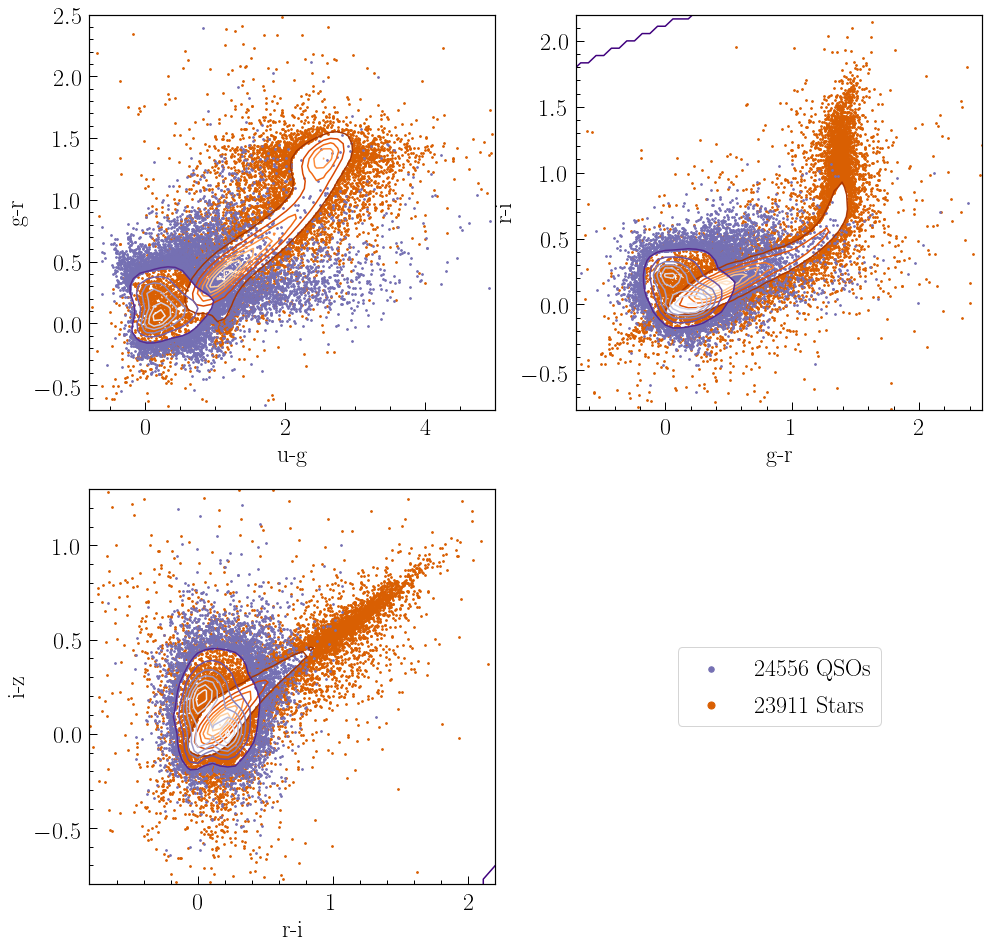

In [17]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsgri2 = np.array([[-2,2], [-2,2]])
limsgri2 = limsgri.flatten()
limsriz = np.array([[-2,3.5], [-2,2.5]])
limsriz = limsriz.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(train_df[starmask]['stdColor[0]'], train_df[starmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[qsomask]['stdColor[0]'], train_df[qsomask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-0.8,5)
        axis.set_ylim(-0.7,2.5)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        #axis.set_yticks(rotation=90)
        
    if i==1:
        contour_scatter(train_df[starmask]['stdColor[1]'], train_df[starmask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[qsomask]['stdColor[1]'], train_df[qsomask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-0.7,2.5)
        axis.set_ylim(-0.8,2.2)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        
    if i==2:
        contour_scatter(train_df[starmask]['stdColor[2]'], train_df[starmask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[qsomask]['stdColor[2]'], train_df[qsomask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        axis.set_xlim(-0.8,2.2)
        axis.set_ylim(-0.8,1.3)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')

    if i==3:
        axis.set_axis_off()
        handles = [plt.scatter([], [], color=csdark[2], s=30),plt.scatter([],[],color=csdark[1],s=50)]
        labels  = [str(qsomask.sum())+' QSOs',str(starmask.sum())+' Stars']
        legend = axis.legend(handles, labels, loc='center')    
        
plt.savefig('/home/idies/workspace/Storage/gtr/persistent/plots/MiMstarqso_varcolors.png')        

It is important for us to realize that the "stars" within the main QSO contours are very likely to be QSOs.  The issue is that we don't have spectra of everything and the stars were selected to be variable.  So the majority of the objects in the region dominated by quasars are very likely to be quasars and will need to be handled carefully.  This is one of the challenges of developing a training set where there are no definitive truth tables.

---

Ignoring the contamination of QSOs in the stars sample, let's start by seeing how well a RF does at classification using colors alone.

In [18]:
Xvarcolors = train_df.drop(['class', 'ra', 'dec', 'log10_dho_amp', 'log10_tau_decay'],axis=1).values
Xvarcolors
print(Xvarcolors.shape)

(48467, 4)


In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
#Instantiate a model with the parameters we decide upon.
model = RandomForestClassifier(n_estimators=50)

In [21]:
#See what fraction are correct
from sklearn.model_selection import cross_val_score
scoresVarColors=cross_val_score(model, Xvarcolors, y, cv=5)
scoresVarColors.mean()

0.9232465704770029

In [22]:
#Get actual predicted values so that we can make plots
from sklearn.model_selection import cross_val_predict
ypredVarColors = cross_val_predict(model, Xvarcolors, y, cv=5)

In [23]:
from sklearn.metrics import confusion_matrix
tp, fn, fp, tn = confusion_matrix(y,ypredVarColors).ravel()
print(tp, tn, fp, fn)

23080 21704 2207 1476


In [24]:
#Make masks for the above to aid in plotting
tpmask = ((y=='qso') & (ypredVarColors=='qso'))
tnmask = ((y=='vStar') & (ypredVarColors=='vStar'))
fpmask = ((y=='vStar') & (ypredVarColors=='qso'))
fnmask = ((y=='qso') & (ypredVarColors=='vStar'))
print(tpmask.sum(),tnmask.sum(),fpmask.sum(),fnmask.sum())

23080 21704 2207 1476


In [25]:
from sklearn.metrics import classification_report
target_names=np.unique(train_df['class'])
print(classification_report(y, ypredVarColors, target_names=target_names))

              precision    recall  f1-score   support

         qso       0.91      0.94      0.93     24556
       vStar       0.94      0.91      0.92     23911

    accuracy                           0.92     48467
   macro avg       0.92      0.92      0.92     48467
weighted avg       0.92      0.92      0.92     48467



Now make plots of the results.

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6]
[ 0.   1.5  3.   4.5  6.   7.5  9.  10.5 12. ]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[0.  1.5 3.  4.5 6.  7.5 9. ]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6]


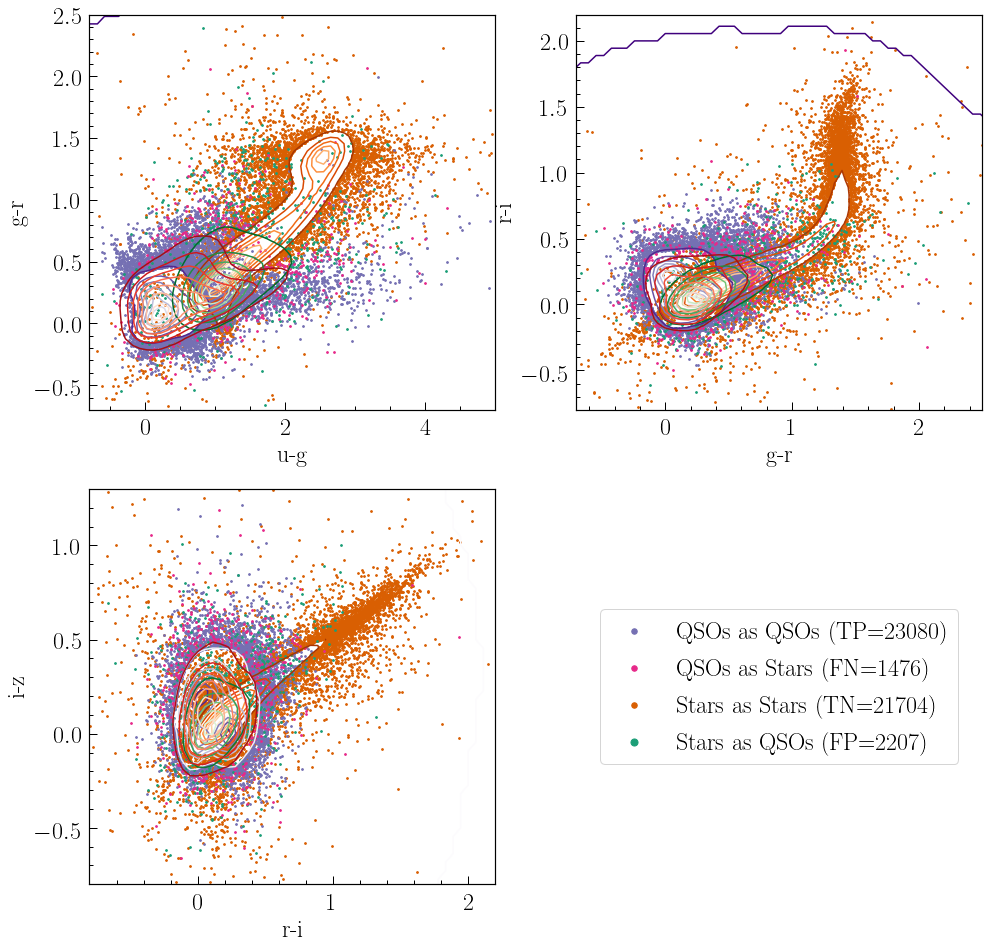

In [26]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsriz = np.array([[-2,3.5], [-2,2.5]])
limsriz = limsriz.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(train_df[tnmask]['stdColor[0]'], train_df[tnmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask]['stdColor[0]'], train_df[tpmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fnmask]['stdColor[0]'], train_df[fnmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask]['stdColor[0]'], train_df[fpmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[0]'], train_df[fnmask]['stdColor[1]'],color=csdark[0],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[0]'], train_df[fpmask]['stdColor[1]'],color=csdark[3],s=3)
        axis.set_xlim(-0.8,5)
        axis.set_ylim(-0.7,2.5)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        
    if i==1:
        contour_scatter(train_df[tnmask]['stdColor[1]'], train_df[tnmask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask]['stdColor[1]'], train_df[tpmask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fnmask]['stdColor[1]'], train_df[fnmask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask]['stdColor[1]'], train_df[fpmask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[1]'], train_df[fnmask]['stdColor[2]'],color=csdark[0],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[1]'], train_df[fpmask]['stdColor[2]'],color=csdark[3],s=3)
        axis.set_xlim(-0.7,2.5)
        axis.set_ylim(-0.8,2.2)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        
    if i==2:
        contour_scatter(train_df[tnmask]['stdColor[2]'], train_df[tnmask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask]['stdColor[2]'], train_df[tpmask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Purples', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        contour_scatter(train_df[fnmask]['stdColor[2]'], train_df[fnmask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask]['stdColor[2]'], train_df[fpmask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[2]'], train_df[fnmask]['stdColor[3]'],color=csdark[0],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[2]'], train_df[fpmask]['stdColor[3]'],color=csdark[3],s=3)
        axis.set_xlim(-0.8,2.2)
        axis.set_ylim(-0.8,1.3)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')

    if i==3:
        axis.set_axis_off()
        #handles = [plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([],[],color=csdark[0],s=50)]
        #labels  = ['Stars as Stars (TN='+str(tnmask.sum())+')', 'QSOs as QSOs (TP='+str(tpmask.sum())+')', 'QSOs as Stars (FN='+str(fnmask.sum())+')', 'Stars as QSOs (FP='+str(fpmask.sum())+')']
        handles = [plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[0],s=50)]
        labels  = ['QSOs as QSOs (TP='+str(tpmask.sum())+')', 'QSOs as Stars (FN='+str(fnmask.sum())+')', 'Stars as Stars (TN='+str(tnmask.sum())+')', 'Stars as QSOs (FP='+str(fpmask.sum())+')']
        legend = axis.legend(handles, labels, loc='center')    

plt.savefig('/home/idies/workspace/Storage/gtr/persistent/plots/MiMstarqso_varcolorsonly.png')  

Note that the number of false positives is misleading as many of those are likely to be real quasars.  But what really seems to be happening is that real quasars are being classified as stars (FN) because there are QSOs in the stars training set, making real QSOs get classified as stars.

Now add the variability information.  First plot the parameters that we are going to use.

[0.   0.15 0.3  0.45 0.6  0.75 0.9  1.05]
[0.   0.15 0.3  0.45 0.6  0.75 0.9  1.05 1.2 ]


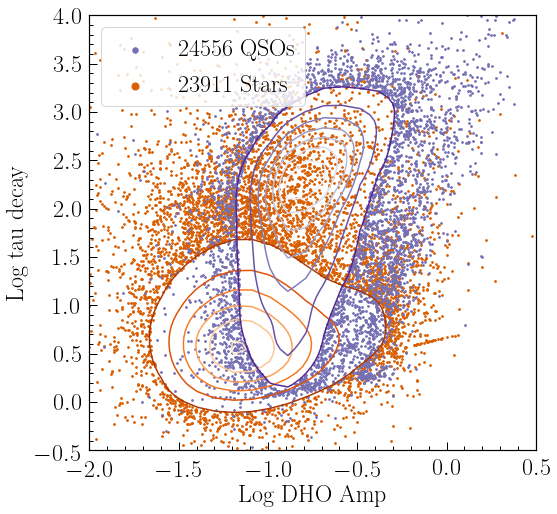

In [28]:
lims = np.array([[-3,1], [-2,5]])
lims = lims.flatten()
levels = None
#levels = [10, 50, 90]
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, axis = plt.subplots(1,1,figsize=(8,8))


handles, labels = (0, 0)

contour_scatter(train_df[starmask]['log10_dho_amp'], train_df[starmask]['log10_tau_decay'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
contour_scatter(train_df[qsomask]['log10_dho_amp'], train_df[qsomask]['log10_tau_decay'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
axis.set_xlim(-2.0,0.5)
axis.set_ylim(-0.5,4.0)
axis.set_xlabel('Log DHO Amp')
axis.set_ylabel('Log tau decay')
#axis.set_yticks(rotation=90)

handles = [plt.scatter([], [], color=csdark[2], s=30),plt.scatter([],[],color=csdark[1],s=50)]
labels  = [str(qsomask.sum())+' QSOs',str(starmask.sum())+' Stars']
legend = axis.legend(handles, labels, loc='best')    
        

plt.savefig('/home/idies/workspace/Storage/gtr/persistent/plots/MiMstarqso_dhoparams.png')  

In [29]:
#Make new "X" that includes the variability parameters
X2 = train_df.drop(['class', 'ra', 'dec'],axis=1).values
X2
print(X2.shape)

(48467, 6)


In [30]:
#See what fraction are correct
from sklearn.model_selection import cross_val_score
scores2=cross_val_score(model, X2, y, cv=5)
scores2.mean()

0.9396290015163477

In [31]:
#Get actual predicted values so that we can make plots
ypred2 = cross_val_predict(model, X2, y, cv=5)

In [32]:
from sklearn.metrics import confusion_matrix
tn2, fp2, fn2, tp2 = confusion_matrix(y,ypred2).ravel()
print(tn2, fp2, fn2, tp2)

23481 1075 1854 22057


In [33]:
#Make masks for the above to aid in plotting
tpmask2 = ((y=='qso') & (ypred2=='qso'))
tnmask2 = ((y=='vStar') & (ypred2=='vStar'))
fpmask2 = ((y=='vStar') & (ypred2=='qso'))
fnmask2 = ((y=='qso') & (ypred2=='vStar'))

In [34]:
target_names=np.unique(train_df['class'])
print(classification_report(y, ypred2, target_names=target_names))

              precision    recall  f1-score   support

         qso       0.93      0.96      0.94     24556
       vStar       0.95      0.92      0.94     23911

    accuracy                           0.94     48467
   macro avg       0.94      0.94      0.94     48467
weighted avg       0.94      0.94      0.94     48467



[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]
[0.   0.15 0.3  0.45 0.6  0.75 0.9  1.05 1.2 ]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[0.  0.6 1.2 1.8 2.4 3.  3.6 4.2]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6]
[ 0.   1.5  3.   4.5  6.   7.5  9.  10.5 12. ]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[0. 1. 2. 3. 4. 5. 6. 7.]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6]


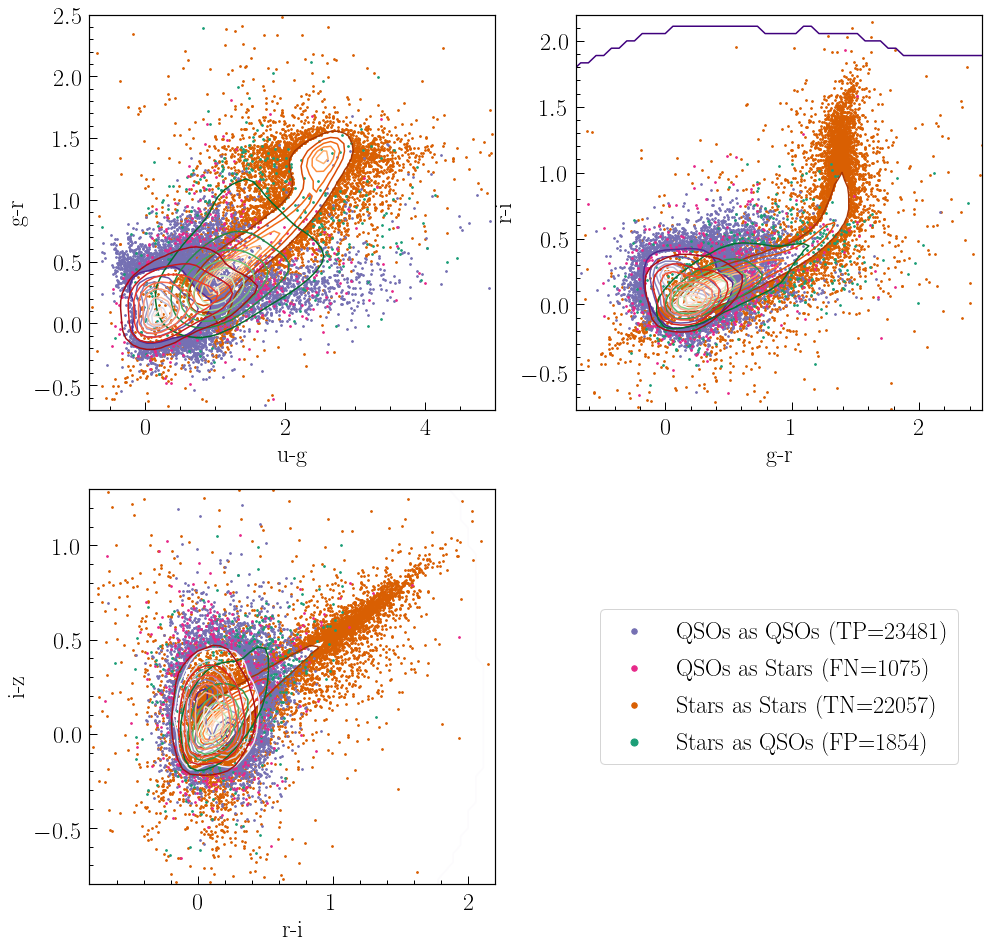

In [35]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsriz = np.array([[-2,3.5], [-2,2.5]])
limsriz = limsriz.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(train_df[tnmask2]['stdColor[0]'], train_df[tnmask2]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask2]['stdColor[0]'], train_df[tpmask2]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fnmask2]['stdColor[0]'], train_df[fnmask2]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask2]['stdColor[0]'], train_df[fpmask2]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[0]'], train_df[fnmask]['stdColor[1]'],color=csdark[3],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[0]'], train_df[fpmask]['stdColor[1]'],color=csdark[0],s=3)
        axis.set_xlim(-0.8,5)
        axis.set_ylim(-0.7,2.5)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        
    if i==1:
        contour_scatter(train_df[tnmask2]['stdColor[1]'], train_df[tnmask2]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask2]['stdColor[1]'], train_df[tpmask2]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fnmask2]['stdColor[1]'], train_df[fnmask2]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask2]['stdColor[1]'], train_df[fpmask2]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[1]'], train_df[fnmask]['stdColor[2]'],color=csdark[3],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[1]'], train_df[fpmask]['stdColor[2]'],color=csdark[0],s=3)
        axis.set_xlim(-0.7,2.5)
        axis.set_ylim(-0.8,2.2)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        
    if i==2:
        contour_scatter(train_df[tnmask2]['stdColor[2]'], train_df[tnmask2]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask2]['stdColor[2]'], train_df[tpmask2]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Purples', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        contour_scatter(train_df[fnmask2]['stdColor[2]'], train_df[fnmask2]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask2]['stdColor[2]'], train_df[fpmask2]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[2]'], train_df[fnmask]['stdColor[3]'],color=csdark[3],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[2]'], train_df[fpmask]['stdColor[3]'],color=csdark[0],s=3)
        axis.set_xlim(-0.8,2.2)
        axis.set_ylim(-0.8,1.3)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')

    if i==3:
        axis.set_axis_off()
        #handles = [plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([],[],color=csdark[0],s=50)]
        #labels  = ['Stars as Stars (TP='+str(tnmask2.sum())+')', 'QSOs as QSOs (TP='+str(tpmask2.sum())+')', 'QSOs as Stars (FN='+str(fnmask2.sum())+')', 'Stars as QSOs (FP='+str(fpmask2.sum())+')']
        handles = [plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[0],s=50)]
        labels  = ['QSOs as QSOs (TP='+str(tpmask2.sum())+')', 'QSOs as Stars (FN='+str(fnmask2.sum())+')', 'Stars as Stars (TN='+str(tnmask2.sum())+')', 'Stars as QSOs (FP='+str(fpmask2.sum())+')']
        legend = axis.legend(handles, labels, loc='center')    

plt.savefig('/home/idies/workspace/Storage/gtr/persistent/plots/MiMstarqso_varcolorswithvar.png')  

So, adding the variability helped, but we'll have to clean up the training sets before knowing just how much.